<a href="https://colab.research.google.com/github/ShirinDehghani/skip-gram/blob/main/skip_gram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# using skip-gram from word2vec for BBC news dataset!

first, we import necessary libraries : 

In [ ]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.python.framework.ops import disable_eager_execution
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.manifold import TSNE
import warnings

In [ ]:
warnings.filterwarnings("ignore")
nltk.download('all') #download all packages of nltk(natural language processing toolkit)
disable_eager_execution() #disable eager execution for because we want use TF v1

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

load `bbc-text.csv` dataset:

In [ ]:
df = pd.DataFrame(pd.read_csv('/content/bbc-text.csv'))
df.head(3)

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...


In [ ]:
# Hyper parameters: 
vocab_size = 100
embedding_dim = 10
window_size = 2
n_iters = 20000

It's time to tokenize sentences and words : 

In [ ]:
corpus = df.text.iloc[0] + df.text.iloc[1] + df.text.iloc[2]
tokenizer = Tokenizer(num_words = vocab_size)
list_of_sents = sent_tokenize(corpus.lower()) 
tokenizer.fit_on_texts(list_of_sents)

data = tokenizer.texts_to_sequences(list_of_sents)
seq = tokenizer.sequences_to_texts(data)

#making sentences of tokenizers
sentences = []
for i in seq:
  sentences.append(i.split(" "))

#tokenizing words
words = ""
for i in seq:
  if i != " ":
    words = words + i + " "
words = words.split(' ')

print('Vocabulary size: \n', len(set(words)))

Vocabulary size: 
 100


In [ ]:
print('2 sentences: \n', sentences[:3])
print("5 words: \n", words[:100])

2 sentences: 
 [['tv', 'in', 'the', 'of', 'viewers', 'with', 'high', 'definition', 'and', 'into', 'the', 'the', 'way', 'people', 'watch', 'tv', 'will', 'be', 'in'], ['that', 'is', 'to', 'an', 'which', 'at', 'the', 'show', 'in', 'to', 'these', 'new', 'technologies', 'will', 'one', 'of'], ['with', 'the', 'us', 'the', 'programmes', 'and', 'content', 'will', 'be', 'to', 'viewers', 'networks', 'satellite', 'telecoms', 'companies', 'and', 'to', 'and']]
5 words: 
 ['tv', 'in', 'the', 'of', 'viewers', 'with', 'high', 'definition', 'and', 'into', 'the', 'the', 'way', 'people', 'watch', 'tv', 'will', 'be', 'in', 'that', 'is', 'to', 'an', 'which', 'at', 'the', 'show', 'in', 'to', 'these', 'new', 'technologies', 'will', 'one', 'of', 'with', 'the', 'us', 'the', 'programmes', 'and', 'content', 'will', 'be', 'to', 'viewers', 'networks', 'satellite', 'telecoms', 'companies', 'and', 'to', 'and', 'one', 'of', 'the', 'about', 'technologies', 'of', 'has', 'been', 'and', 'dvr', 'and', 'these', 'the', 'us',

In [ ]:
#make indexes of each words
word2int = {}
int2word = {}
for i,word in enumerate(words):
    word2int[word] = i
    int2word[i] = word

generate training data : 

In [ ]:
train_pairs = []
for sentence in sentences:
    for word_index, word in enumerate(sentence):
        for nb_word in sentence[max(word_index - window_size, 0) : min(word_index + window_size, len(sentence)) + 1] : 
            if nb_word != word:
                train_pairs.append([word, nb_word])

In [ ]:
train_pairs[:10]

[['tv', 'in'],
 ['tv', 'the'],
 ['in', 'tv'],
 ['in', 'the'],
 ['in', 'of'],
 ['the', 'tv'],
 ['the', 'in'],
 ['the', 'of'],
 ['the', 'viewers'],
 ['of', 'in']]

In [ ]:
# function to convert numbers to one hot vectors
def to_one_hot(data_point_index, vocab_size):
    temp = np.zeros(len(words))
    temp[data_point_index] = 1
    return temp
x_train = [] # input word
y_train = [] # output word
for data_word in train_pairs:
    x_train.append(to_one_hot(word2int[ data_word[0] ], len(words)))
    y_train.append(to_one_hot(word2int[ data_word[1] ], len(words)))
# convert them to numpy arrays
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

In [ ]:
x = tf.compat.v1.placeholder(tf.float32, shape=(None, len(words)))
y_label = tf.compat.v1.placeholder(tf.float32, shape=(None, len(words)))

In [ ]:
W1 = tf.compat.v1.Variable(tf.compat.v1.random_normal([len(words), embedding_dim]))
b1 = tf.compat.v1.Variable(tf.compat.v1.random_normal([embedding_dim])) #bias
hidden_representation = tf.add(tf.matmul(x,W1), b1)

W2 = tf.compat.v1.Variable(tf.compat.v1.random_normal([embedding_dim, len(words)]))
b2 = tf.compat.v1.Variable(tf.compat.v1.random_normal([len(words)]))
prediction = tf.nn.softmax(tf.add( tf.matmul(hidden_representation, W2), b2))

sess = tf.compat.v1.Session()
init = tf.compat.v1.global_variables_initializer()
sess.run(init) #make sure you do this!

# define the loss function:
cross_entropy_loss = tf.compat.v1.reduce_mean(-tf.compat.v1.reduce_sum(y_label * tf.compat.v1.log(prediction), reduction_indices=[1]))
# define the training step:
train_step = tf.compat.v1.train.GradientDescentOptimizer(0.1).minimize(cross_entropy_loss)
# train for n_iter iterations
for _ in range(n_iters):
    sess.run(train_step, feed_dict={x: x_train, y_label: y_train})
    print('loss is : ', sess.run(cross_entropy_loss, feed_dict={x: x_train, y_label: y_train}))

Streaming output truncated to the last 5000 lines.
loss is :  3.6127882
loss is :  3.6127741
loss is :  3.6127596
loss is :  3.6127453
loss is :  3.6127307
loss is :  3.612717
loss is :  3.6127024
loss is :  3.6126883
loss is :  3.612674
loss is :  3.61266
loss is :  3.6126456
loss is :  3.612631
loss is :  3.6126173
loss is :  3.6126027
loss is :  3.6125886
loss is :  3.6125743
loss is :  3.6125603
loss is :  3.612546
loss is :  3.6125314
loss is :  3.6125174
loss is :  3.6125028
loss is :  3.6124885
loss is :  3.6124744
loss is :  3.6124606
loss is :  3.612446
loss is :  3.6124322
loss is :  3.6124177
loss is :  3.6124036
loss is :  3.6123893
loss is :  3.6123753
loss is :  3.612361
loss is :  3.6123464
loss is :  3.6123323
loss is :  3.612318
loss is :  3.612304
loss is :  3.6122897
loss is :  3.6122756
loss is :  3.612261
loss is :  3.6122472
loss is :  3.612233
loss is :  3.6122189
loss is :  3.6122043
loss is :  3.6121905
loss is :  3.612176
loss is :  3.6121616
loss is :  3.6121

In [ ]:
vectors = sess.run(W1 + b1)

In [ ]:
def euclidean_dist(vec1, vec2):
    return np.sqrt(np.sum((vec1-vec2)**2))
    
def find_closest(word_index, vectors):
    min_dist = 10000 # to act like positive infinity
    min_index = -1
    query_vector = vectors[word_index]
    for index, vector in enumerate(vectors):
        if euclidean_dist(vector, query_vector) < min_dist and not np.array_equal(vector, query_vector):
            min_dist = euclidean_dist(vector, query_vector)
            min_index = index
    return min_index

In [ ]:
print(int2word[find_closest(word2int['new'], vectors)])

watch


[[-0.5016975  -0.8650431 ]
 [-0.03507098 -0.9993848 ]
 [-0.0762772  -0.9970867 ]
 ...
 [ 0.94889957  0.31557825]
 [-0.8739385  -0.48603645]
 [-0.675769    0.7371135 ]]
['tv', 'in', 'the', 'of', 'viewers', 'with', 'high', 'definition', 'and', 'into', 'the', 'the', 'way', 'people', 'watch', 'tv', 'will', 'be', 'in', 'that', 'is', 'to', 'an', 'which', 'at', 'the', 'show', 'in', 'to', 'these', 'new', 'technologies', 'will', 'one', 'of', 'with', 'the', 'us', 'the', 'programmes', 'and', 'content', 'will', 'be', 'to', 'viewers', 'networks', 'satellite', 'telecoms', 'companies', 'and', 'to', 'and', 'one', 'of', 'the', 'about', 'technologies', 'of', 'has', 'been', 'and', 'dvr', 'and', 'these', 'the', 'us', 's', 'tivo', 'and', 'the', 'uk', 's', 'people', 'to', 'play', 'and', 'tv', 'programmes', 'when', 'they', 'want', 'the', 'for', 'much', 'more', 'tv', 'they', 'are', 'also', 'being', 'in', 'to', 'high', 'definition', 'tv', 'which', 'are', 'big', 'in', 'and', 'the', 'us', 'but', 'to', 'take', 'i

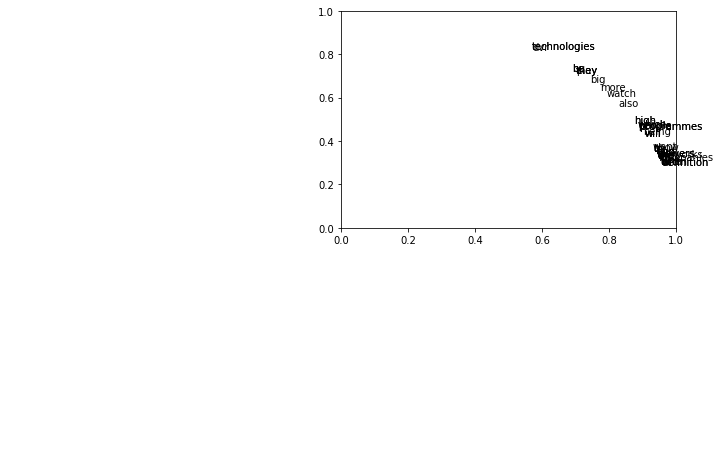

In [ ]:
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
vectors = model.fit_transform(vectors) 

from sklearn import preprocessing

normalizer = preprocessing.Normalizer()
vectors =  normalizer.fit_transform(vectors, 'l2')

print(vectors)

import matplotlib.pyplot as plt


fig, ax = plt.subplots()
print(words)
for word in words[:100]:
    #print(word, vectors[word2int[word]][1])
    ax.annotate(word, (vectors[word2int[word]][0],vectors[word2int[word]][1] ))
plt.show()